In [9]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [10]:
%matplotlib notebook

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
	\label{poisson2d:laplace}
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [15]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    #set h value
    #set discretized x value
    x, h = np.linspace(a, b, n+1, retstep=True)
    h2 = h**2
    y = np.linspace(c, d, n+1)
    #helper function to set up sparse A matrix
    def set_up_sparse_A(m):
        #set up a sparse little matrix
        B = sp.lil_matrix((m, m))
        #set the diagnonal elements to 4
        B.setdiag(-4)
        #set up the 1s and -1s next to the diagonal
        B.setdiag(1, -1)
        B.setdiag(1, 1)
        #set up a sparse block diagonal matrix with B
        A = sp.block_diag([B] * m)
        #set up identity matrix around B
        A.setdiag([1] * m**2, m)
        A.setdiag([1] * m**2, -m)
        return A
    
    #divide by h2 and set to a csr matrix
    A = set_up_sparse_A(n-1) / h2
    A = A.tocsr()

    #define p vector
    p = np.zeros(n-1)
    p[0] = g(x[0], y[1])
    p[-1] = g(x[-1], y[1])
    for j in range(2, n):
        new_p = np.zeros(n-1)
        new_p[0] = g(x[0], y[j])
        new_p[-1] = g(x[-1], y[j])
        p = np.hstack((p, new_p))
    p /= h2

    #define q vector
    q1 = g(x[1:-1], y[0])
    q_n_1 = g(x[1:-1], y[0])
    qj = np.zeros((n-1)*(n-3))
    q = np.hstack((q1, qj, q_n_1))
    q /= h2

    #define f vector
    f_vec = f(x[1:-1], y[1])
    for j in range(2, n):
        temp = f(x[1:-1], y[j])
        f_vec = np.hstack((f_vec, temp))
                
    #set up boundary conditions
    X, Y = np.meshgrid(x, y)
    U = g(X, Y)
    #solve
    Y = spla.spsolve(A, f_vec-p-q)
    #reshape
    Y = Y.reshape(n-1, n-1)
    #reset middle part of U
    U[1:-1, 1:-1] = Y
    
    return U

<IPython.core.display.Javascript object>


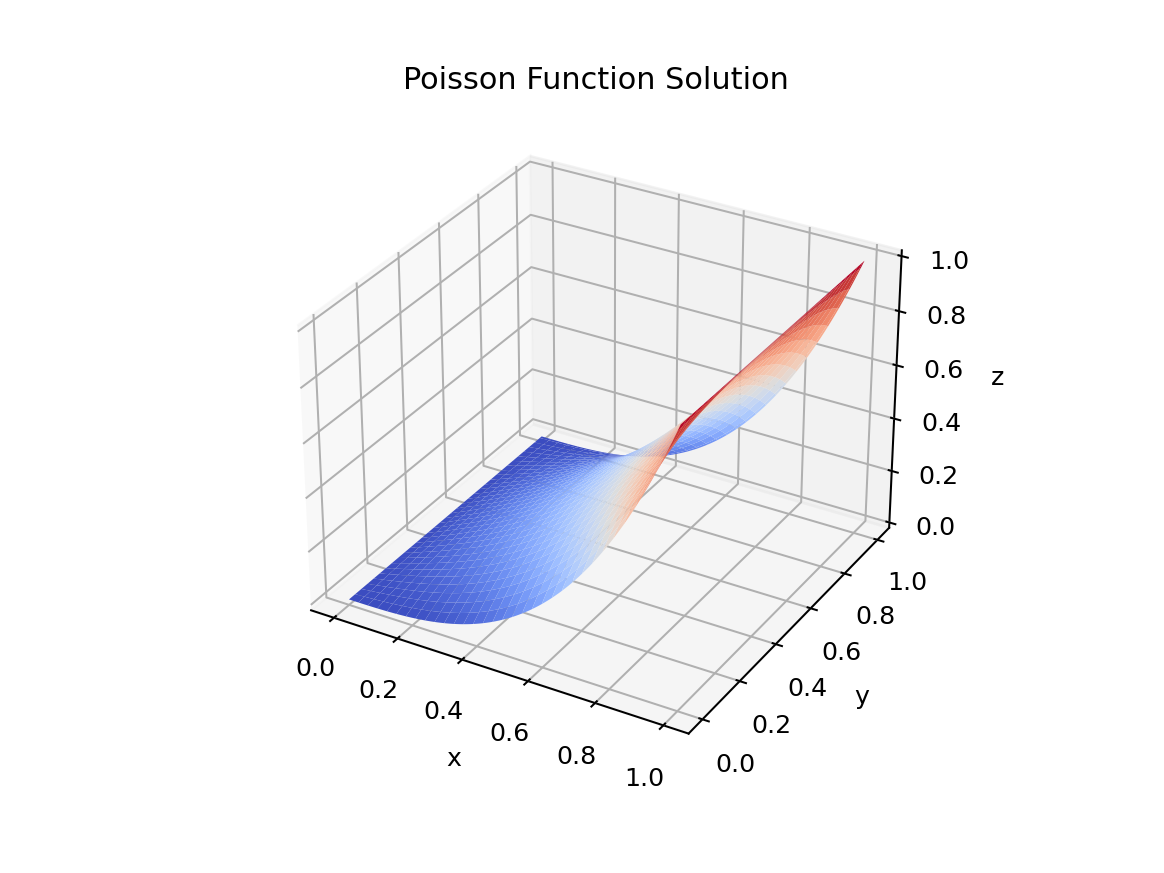

In [16]:
def problem1():
    #set constants
    a, b, c, d = 0, 1, 0, 1
    #lamda functions for source/sinks and boundary
    f = lambda x, y: x*0
    g = lambda x, y: x**3
    #n values
    n = 100
    #set up mesh grid for plotting
    x = np.linspace(0, 1, n+1)
    y = np.linspace(0, 1, n+1)
    X, Y = np.meshgrid(x, y)
    #solve
    U = poisson_square(a, b, c, d, f, g, n)
    #plot
    fig = plt.figure()
    fig.set_dpi(100)
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X,Y,U,cmap='coolwarm')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Poisson Function Solution')
    plt.show()
    return

problem1()

# Problem 2

Solve 

\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

<IPython.core.display.Javascript object>


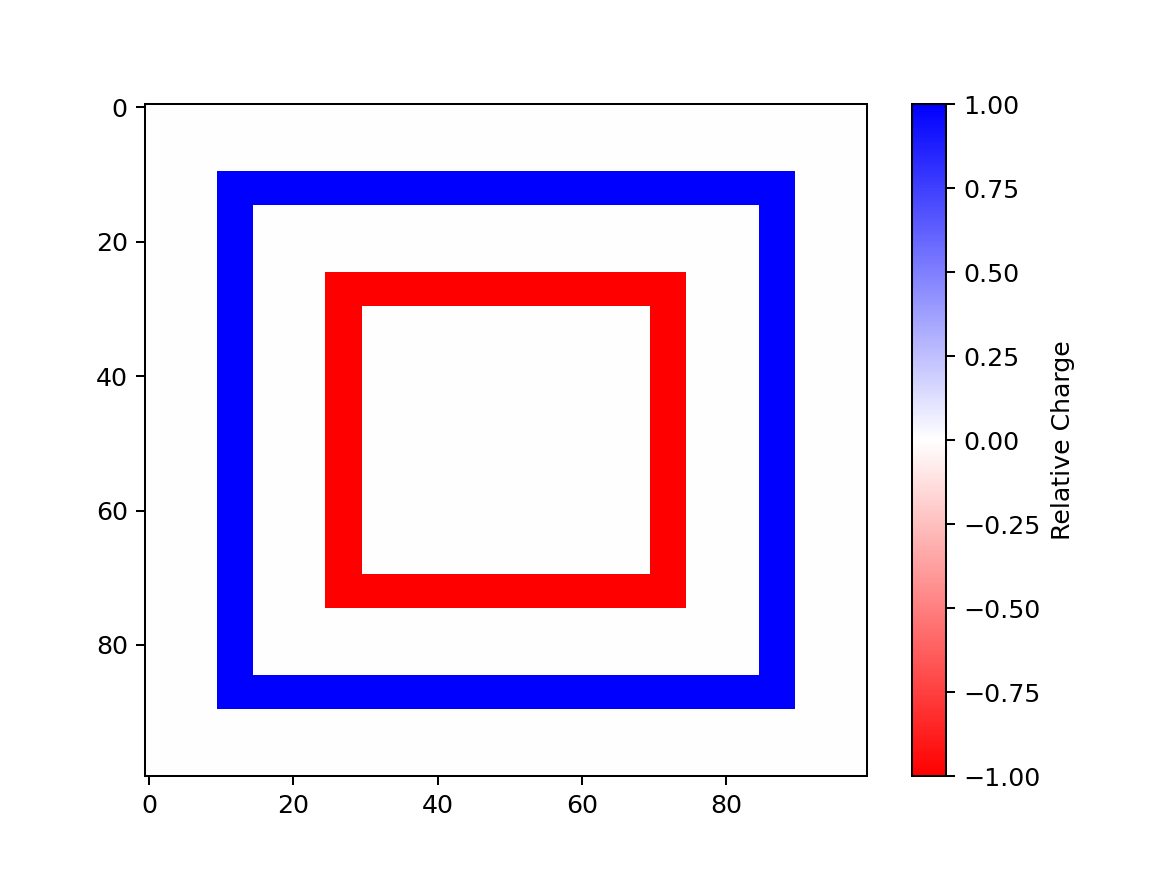

In [19]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

plt.imshow(source(X,Y),cmap = mcolors.LinearSegmentedColormap('cmap', genDict(source(X,Y))), aspect='auto')
plt.colorbar(label="Relative Charge")
plt.show()


<IPython.core.display.Javascript object>


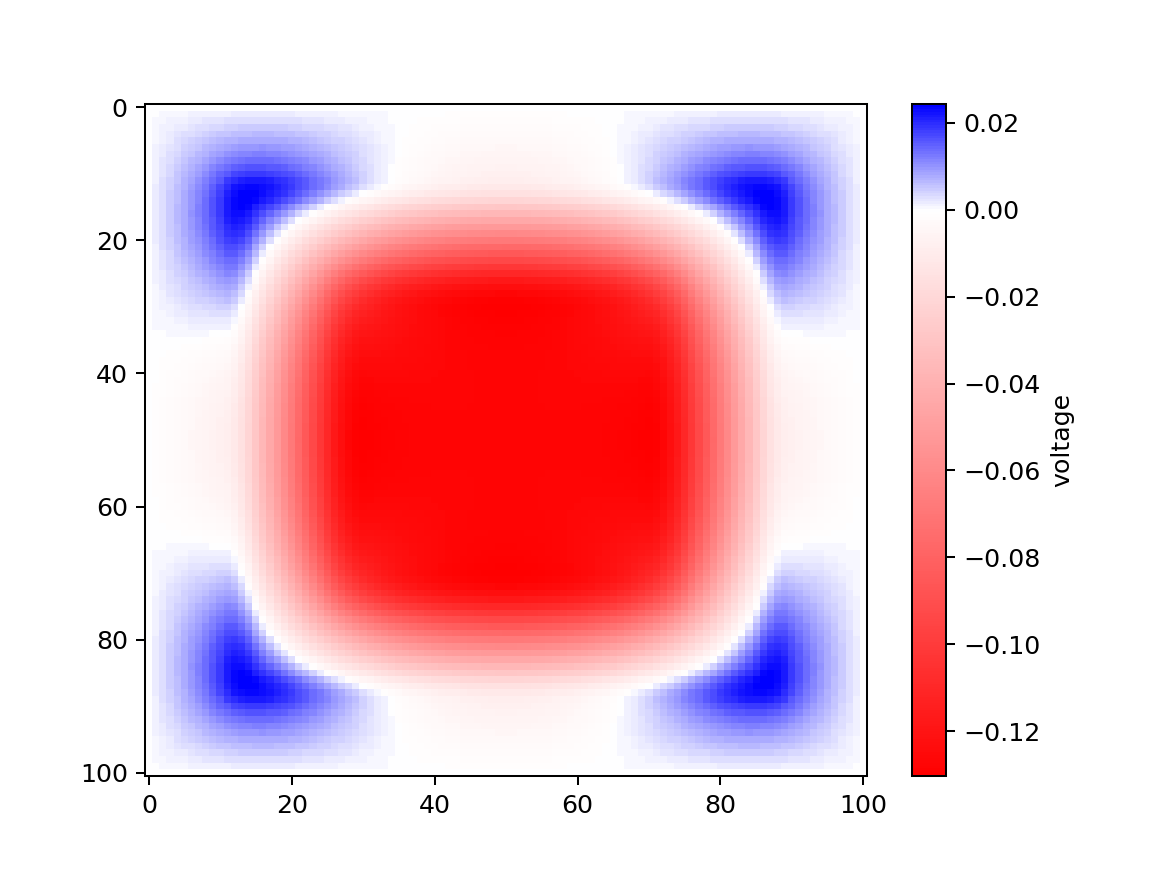

In [21]:
g = lambda x, y: x*0
f = lambda x, y: -1 * source(x, y)
U = poisson_square(a1, b1, c1, d1, f, g, 100)
plt.imshow(U, cmap = mcolors.LinearSegmentedColormap('cmap', genDict(U)), aspect='auto')
plt.colorbar(label = "voltage")
plt.show()